In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import dirname
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import lime

notebook_path = os.path.abspath("DataAnalyticsKickstarterNotebook_Cedrik.ipynb")
csv_path_features = os.path.join(os.path.dirname(dirname(notebook_path)), "data/ks-project-edited-klassifikation-features.csv")
csv_path_trueLabels = os.path.join(os.path.dirname(dirname(notebook_path)), "data/ks-project-edited-klassifikation-target.csv")

In [91]:
df_features = pd.read_csv (csv_path_features, low_memory=False)
df_target = pd.read_csv (csv_path_trueLabels, low_memory=False)

In [31]:
df_features.head()

,usd_goal_real,duration,name_length,creator_type,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1.981553e-05,0.208791,0.221053,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3.302593e-05,0.153846,0.336842,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.302534e-06,0.142857,0.368421,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3.301939e-07,0.076923,0.157895,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1.321033e-05,0.879121,0.473684,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [32]:
df_target.head()

,ID,successful
0,558744194,1
1,134175247,1
2,1577455391,1
3,171893227,1
4,499552311,1


In [33]:
X_train, X_dev, y_train, y_dev = train_test_split(df_features, df_target["successful"], random_state=42)

In [34]:
# Klassifizierer wählen
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False, gamma=10, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',random_state=0, reg_alpha=0, 
                               reg_lambda=1, scale_pos_weight=1, subsample=1,tree_method='exact', 
                               use_label_encoder=False, validate_parameters=1, verbosity=None, eval_metric='logloss')

In [35]:
# Anzahl der fehlgeschlagen (0) und erfolgreichen Projekte (1) in den Trainingsdaten
print("Gesamtzahl Datenpunkte Training: ", len(y_train))

for i in range(2):
    print("Anzahl Kategorie", str(i), list(y_train).count(i))

Gesamtzahl Datenpunkte Training:  97185
Anzahl Kategorie 0 46451
Anzahl Kategorie 1 50734


In [36]:
# Nun für die Testdaten
print("Gesamtzahl Datenpunkte Dev: ", len(y_dev))
for i in range(2):
    print("Anzahl Kategorie", str(i), list(y_dev).count(i))

Gesamtzahl Datenpunkte Dev:  32395
Anzahl Kategorie 0 15302
Anzahl Kategorie 1 17093


In [37]:
classifier.fit(X_train, y_train)

pred_freq = np.full(len(y_dev),1)
predicted = classifier.predict(X_dev)

In [38]:
print("Trainiertes Modell, F1-Score: ", f1_score(y_dev, predicted, average='weighted'))
print("Frequenzbaseline, F1-Score: ",f1_score(y_dev, pred_freq, average='weighted'))

Trainiertes Modell, F1-Score:  0.7348683427990677
Frequenzbaseline, F1-Score:  0.3644925818432922


In [39]:
# Vergleichsbaseline definieren
# Pipeline mit optimalen Parametern aus Klassifikation Notebook
baseline_pipeline = Pipeline(steps=[('feature_selection',SelectFromModel(estimator=LinearSVC(dual=False, max_iter=2000,
                                                     penalty='l1'))),
                                    ('classifier', GaussianNB())])

baseline_pipeline.fit(X_train, y_train)
predicted_nb = baseline_pipeline.predict(X_dev)

In [40]:
print("Modell XGBoost\n", classification_report(y_dev, predicted))
print("Modell Naive Bayes\n", classification_report(y_dev, predicted_nb))

Modell XGBoost
               precision    recall  f1-score   support

           0       0.73      0.70      0.71     15302
           1       0.74      0.77      0.75     17093

    accuracy                           0.74     32395
   macro avg       0.73      0.73      0.73     32395
weighted avg       0.74      0.74      0.73     32395

Modell Naive Bayes
               precision    recall  f1-score   support

           0       0.72      0.33      0.45     15302
           1       0.59      0.88      0.71     17093

    accuracy                           0.62     32395
   macro avg       0.66      0.61      0.58     32395
weighted avg       0.65      0.62      0.59     32395



In [41]:
def plot_learning_curves(model, X_train,y_train, X_dev, y_dev):
    train_fs, dev_fs = [], []
    for m in range(100, X_train.shape[0],100):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_dev_predict = model.predict(X_dev)
        train_fs.append(f1_score(y_train[:m], y_train_predict,average='weighted'))
        dev_fs.append(f1_score(y_dev, y_dev_predict, average='weighted'))
    plt.plot(train_fs, "r-+", linewidth=2, label="train")
    plt.plot(dev_fs, "b-", linewidth=3, label="dev")
    plt.legend()
    plt.xlabel('Index der Trainingsiteration')
    plt.ylabel('F-Score des Lerners')

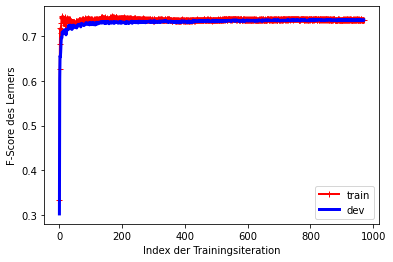

In [102]:
plot_learning_curves(classifier, X_train, y_train, X_dev, y_dev)

In [86]:
X_train_lime, X_dev_lime, y_train_lime, y_dev_lime = train_test_split(df_features.values, df_target["successful"].values, random_state=42)
# Klassifizierer wählen
classifier_lime = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False, gamma=10, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',random_state=0, reg_alpha=0, 
                               reg_lambda=1, scale_pos_weight=1, subsample=1,tree_method='exact', 
                               use_label_encoder=False, validate_parameters=1, verbosity=None, eval_metric='logloss')

classifier_lime.fit(X_train_lime, y_train_lime)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=10, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [103]:
from lime import lime_tabular
feature_names=list(df_features)
class_names = ["failed","successful"]
explainer = lime_tabular.LimeTabularExplainer(training_data= X_train_lime,feature_names=list(df_features))

In [104]:
i = 83
exp = explainer.explain_instance(X_dev_lime[i], classifier.predict_proba, num_features=19)

In [105]:
print(classifier.predict_proba([X_dev_lime[i]]).round(3))

ValueError: training data did not have the following fields: usd_goal_real, duration, name_length, creator_type, Art, Comics, Crafts, Dance, Design, Fashion, Film & Video, Food, Games, Journalism, Music, Photography, Publishing, Technology, Theater

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

In [100]:
idx = 83
exp = explainer.explain_instance(X_dev_lime[i], classifier.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(failed) =', classifier.predict_proba([X_dev_lime[idx]])[0,0])
print('True class: %s' % class_names[y_dev_lime[idx]])



Document id: 83
Probability(failed) = 0.5537654
True class: failed


In [87]:
exps_successful={}
exps_failed={}

list_of_maps=[exps_failed, exps_successful]

# Achtung, läuft lange!

for idx in range(0,len(y_dev_lime)):
    
    # Das beste Label für jede Instanz erklären

    exp = explainer.explain_instance(X_dev_lime[idx], classifier_lime.predict_proba, num_samples=5000, num_features=6, top_labels=1)
    # Die wichtigsten sechs Features für das top_label und ihre Evidenzen (wenn positiv) ablegen
    top_label = exp.available_labels()[0] 
    feature_list = exp.as_list(top_label)

    for rep,w in feature_list:
        # nur positive Evidenzen zählen
        if w<0:
            continue
        if rep in list_of_maps[top_label]:
            list_of_maps[top_label][rep] += w
        else: 
            list_of_maps[top_label][rep] = w
    

In [88]:
# Klasse "failed"
dict(sorted(exps_failed.items(), key=lambda item: item[1], reverse=True))

{'usd_goal_real > 0.00': 2764.5991775286675,
 'creator_type <= 0.00': 2124.0184369833955,
 'Music <= 0.00': 474.12241016210334,
 'duration > 0.37': 319.47834139144135,
 'Food > 0.00': 264.03120617148676,
 'Photography > 0.00': 205.56742198638307,
 'Crafts > 0.00': 190.29305459883324,
 'Film & Video <= 0.00': 102.27204361808997,
 'Journalism > 0.00': 31.262198994806624,
 'name_length <= 0.21': 20.570947606042598,
 'Publishing <= 0.00': 5.628780881144418,
 'Dance <= 0.00': 1.887763306202799,
 'Comics <= 0.00': 0.8589544996158993,
 'Design > 0.00': 0.29070877831492337}

In [89]:
# Klasse "successful"
dict(sorted(exps_successful.items(), key=lambda item: item[1], reverse=True))

{'Crafts <= 0.00': 3486.8951097819554,
 'Photography <= 0.00': 3456.2547704435697,
 'Food <= 0.00': 1679.1610310307362,
 '0.00 < usd_goal_real <= 0.00': 1430.0756507930917,
 'usd_goal_real <= 0.00': 1146.4748265960914,
 'creator_type > 0.00': 893.822335412481,
 'Journalism <= 0.00': 536.4197109486428,
 'Music > 0.00': 186.2812605104179,
 'duration <= 0.32': 99.41819487972892,
 'Film & Video > 0.00': 48.92083634401246,
 'Publishing > 0.00': 3.65062432056077,
 'name_length > 0.49': 0.8773252672244993,
 'Dance > 0.00': 0.5368474109987326,
 'Design <= 0.00': 0.41399589771944534,
 'Comics > 0.00': 0.35014880241508706}